In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad


In [2]:
df_modtran = pd.read_csv('DWD_code_data/MODTRAN.csv')
df_measured = pd.read_csv('DWD_code_data/clear_sky_measured/temp.csv')
# df_measured_fit = pd.read_csv('DWD_code_data/clear_sky_measured/Measured_clear_sky.csv')
df_DWD = pd.read_csv('DWD_code_data/DWD_final_data.csv')
df_solpos = pd.read_csv('DWD_code_data/sol_pos.csv')
df_ozone = pd.read_csv('DWD_code_data/ozone.csv')
df_look_up = pd.read_csv('DWD_code_data/look_up.csv')
# df_solpos
df_solpos['DateTime'] = pd.to_datetime(df_solpos['DateTime'])
df_DWD['DateTime'] = pd.to_datetime(df_DWD['DateTime'])
df_ozone['DateTime'] = pd.to_datetime(df_ozone['DateTime'])

# df_ozone['DateTime']
# df_measured.shape

In [3]:
import sys
h = 6.626e-34
c = 2.99e8
k = 1.38e-23
# T = 22+273.3
T = 20+273.3

def integration(lamda,h,c,k,T):
    var = (2*h*c**2/(lamda**5))*(1/(np.exp(h*c/(lamda*k*T)) -1))
    return var

# res = quad(integration,8e-6,14e-6,args = (h,c,k,T))[0]
# df_measured['rad'] = df_measured['Temp'].apply(lambda x: quad(integration,8e-6,14e-6,args = (h,c,k,x+273.3))[0])
# df_measured_fit['rad'] = df_measured_fit['Temp'].apply(lambda x: quad(integration,8e-6,14e-6,args = (h,c,k,x+273.3))[0])

def brightness_temp(L):

    fit4 = np.array([-7.00668151e-06,  1.34942027e-03, -1.03836055e-01,  5.05728049e+00,
            1.75745362e+02])

    T = np.multiply(fit4[0],np.power(L,4)) +\
                np.multiply(fit4[1],np.power(L,3)) + \
                np.multiply(fit4[2],np.power(L,2)) + \
                np.multiply(fit4[3],np.power(L,1)) + fit4[4]
    return T

In [4]:
from datetime import datetime
time = datetime.strptime('2020-08-12 15:00:00','%Y-%m-%d %H:%M:%S')
time_oz = datetime.strptime('2020-08-12','%Y-%m-%d')
# df_ozone[(df_ozone.DateTime > '2020-08-12 15:00:00') & (df_ozone.DateTime < '2020-08-13 15:00:00')]
# print(time)
oz = df_ozone[df_ozone.DateTime == time_oz]['O3_Nearest'].values
# time - 
solpos = df_solpos[df_solpos.DateTime == time]['sza'].values
dwd = df_DWD[df_DWD.DateTime == time]
cwv = dwd['CWV'].values
aod = dwd['AOD'].values

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

model_rad = df_modtran[(df_modtran.sza == find_nearest(df_modtran['sza'],solpos))&\
          (df_modtran.oz == find_nearest(df_modtran['oz'],oz))&\
          (df_modtran.cwv == find_nearest(df_modtran['cwv'],cwv))&\
          (df_modtran.aot == find_nearest(df_modtran['aot'],aod))&\
          (df_modtran.raa == 0)][['vza','pth_thrml']]

# model_0
# print(df_look_up)
# Temp = []
# for i in model_0['pth_thrml']:
# # #     print(i)
#     T = df_look_up[df_look_up.Radiance == find_nearest(df_look_up['Radiance'],i)]['Temperature'].values
#     Temp.append(T)
# model_0['Temp']= model_0['pth_thrml'].apply(lambda x: float(df_look_up[df_look_up.Radiance == find_nearest(df_look_up['Radiance'],x)]['Temperature'].values))
model_rad['Temp'] = model_rad['pth_thrml'].apply(brightness_temp)
df_measured['Temp'] = df_measured['Temp'].apply(lambda x: x +273.3)
model_rad = model_rad.rename(columns ={'vza':'zenith'})

In [35]:
# df_measured

In [38]:
# model_rad

In [39]:
# df_measured.info()

plt.plot()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   zenith  18 non-null     int64  
 1   Temp    18 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 416.0 bytes


[[  0.          13.854657   229.2112746 ]
 [ 10.          13.962826   229.52242954]
 [ 20.          14.298086   230.4786064 ]
 [ 30.          14.8978015  232.15857584]
 [ 40.          15.8376925  234.71543648]
 [ 50.          17.2653315  238.43071459]
 [ 60.          19.4854565  243.83732879]
 [ 70.          23.236995   252.08260737]
 [ 80.          30.8820225  266.26651035]]
[[  0.  232.9]
 [ 10.  232.6]
 [ 20.  230.9]
 [ 30.  233.6]
 [ 40.  237.4]
 [ 50.  242.3]
 [ 60.  247.4]
 [ 70.  257.4]
 [ 80.  271.9]]
[-1.60931237 -1.34085826 -0.18283415 -0.62087914 -1.14375243 -1.62281332
 -1.46108524 -2.10938497 -2.11573346]


No handles with labels found to put in legend.


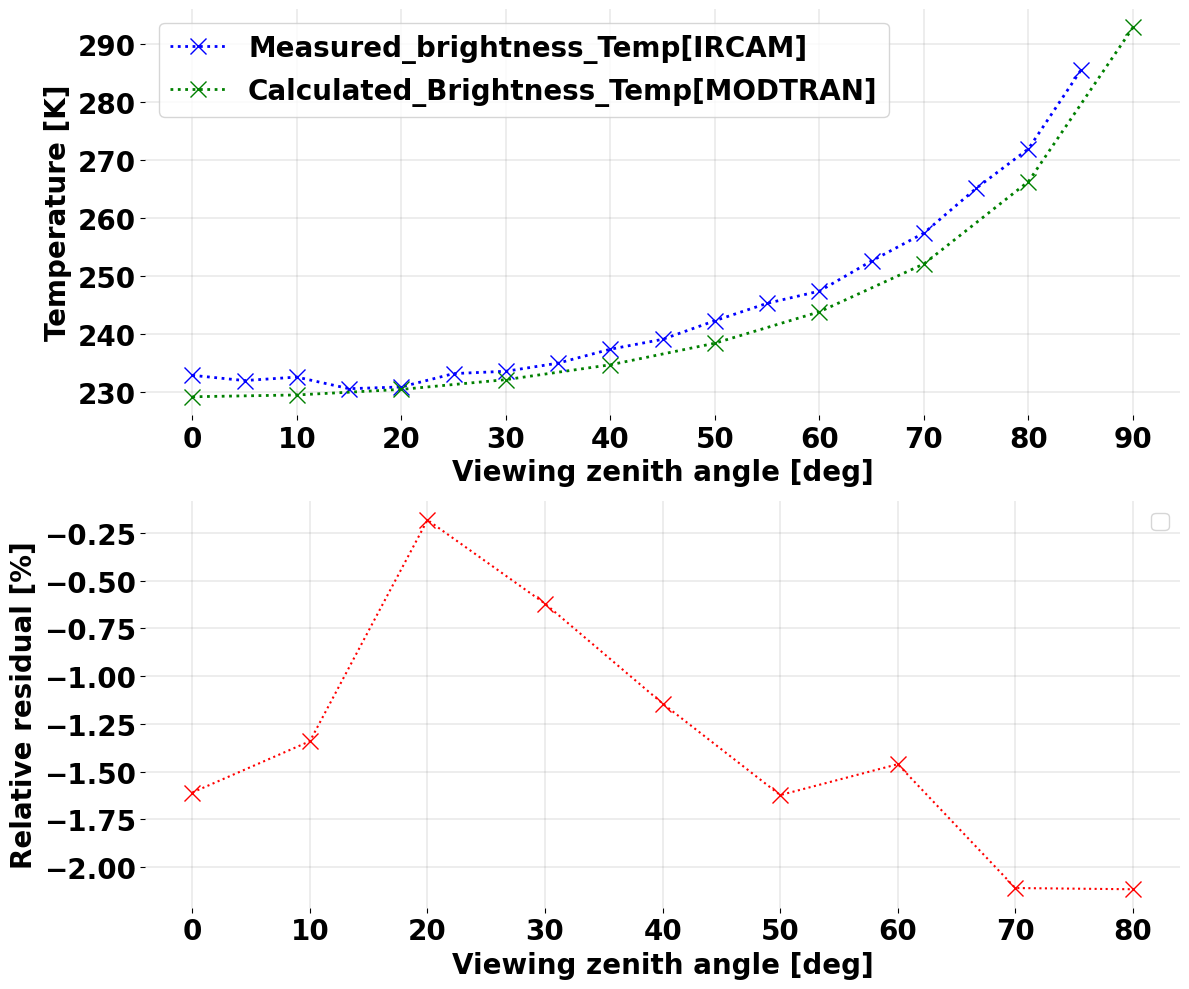

In [93]:
from jupyterthemes import jtplot
jtplot.reset()

residual_act = (model_rad['Temp'].values[:-1] - df_measured['Temp'].values[0::2])*100/model_rad['Temp'].values[:-1]
print(model_rad.values[:-1])
print(df_measured.values[0::2])
print(residual_act)

fig = plt.figure(figsize = (12,10))

plt.subplot(2,1,1)
plt.plot(df_measured['zenith'],df_measured['Temp'],'bx:',markersize = 12,linewidth = 2,label = 'Measured_brightness_Temp[IRCAM]')
# plt.plot(df_measured_fit['zenith'],df_measured_fit['Temp'],'r-')
plt.plot(model_rad['zenith'],model_rad['Temp'],'gx:',markersize = 12,linewidth = 2,label = 'Calculated_Brightness_Temp[MODTRAN]')
plt.legend(loc = 'best',prop = {'size':20,'weight':'bold'})
plt.xticks(np.arange(0,100,10),fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.xlabel('Viewing zenith angle [deg]',fontweight = 'bold' ,size = 20)
plt.ylabel('Temperature [K]',fontweight = 'bold',size = 20 )
# plt.xlim()
plt.grid(color = 'gray', linewidth = 0.2)
plt.box()
plt.tight_layout()

plt.subplot(2,1,2)
# plt.plot(measured_fit['zenith'][0::2].values[:-1], residual_fit[0::2].values[:-1],'x:',markersize = 12)
plt.plot(df_measured['zenith'][0::2], residual_act,'rx:',markersize = 12)
plt.legend(loc = 'best',prop = {'size':16,'weight':'bold'})
plt.xticks(fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.xlabel('Viewing zenith angle [deg]',fontweight = 'bold',size = 20)
plt.ylabel('Relative residual [%]',fontweight = 'bold',size = 20)
plt.grid(color = 'gray', linewidth = 0.2)
plt.tight_layout()
plt.box()
plt.show()

In [24]:
# np.arange(0,92,2)

diff = df_measured['Temp'].values[0::2] - model_rad['Temp'].values[:-1]

# plt.plot(model_rad['zenith'].values[:-1], diff,'*:')
print('variance: ', np.var(diff))
print('mean: ', np.mean(diff))

variance:  2.469794552364274
mean:  3.2996128919114307


285.40000000000003
292.79175709813114


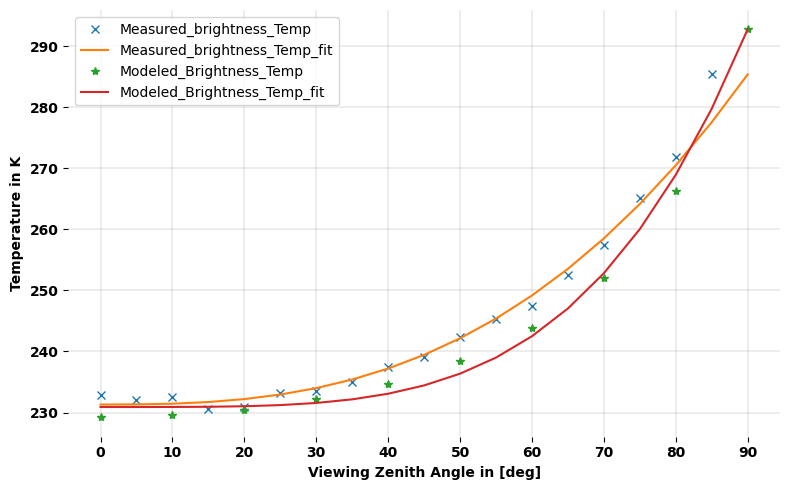

In [30]:

def func(x0,x,T_90):
    return (T_90 - x0[0])*((x/90)**x0[1]) + x0[0]

def residuals(x0, Ydata_cloudy, Xdata_cloudy,T_90):
    return Ydata_cloudy - func(x0,Xdata_cloudy,T_90)

def gen_data(x0,x,T_90):
    return (T_90 - x0[0])*((x/90)**x0[1]) + x0[0]

def smith_fit(data,angle_range):
    from scipy.optimize import leastsq
    Ydata = data['Temp'].values
    Xdata =data['zenith'].values 
    
    T_90 = np.max(Ydata) 
    print(T_90)
    x0 = np.array([-6.54181651,2.66781379], dtype = float)
    x_fit, flag_cloudy = leastsq(residuals, x0,\
                                args=(Ydata, Xdata,T_90))
    model_fit = gen_data(x_fit,angle_range,T_90)
    df_modeled = pd.DataFrame({'zenith':angle_range[:],'Temp':model_fit[:]})
    return df_modeled

measured_fit = smith_fit(df_measured,np.arange(0,95,5))
modeled_fit = smith_fit(model_rad,np.arange(0,95,5))


plt.figure(figsize = (8,5))
plt.plot(df_measured['zenith'],df_measured['Temp'],'x',label = 'Measured_brightness_Temp' )
plt.plot(measured_fit['zenith'],measured_fit['Temp'],label = 'Measured_brightness_Temp_fit')


plt.plot(model_rad['zenith'],model_rad['Temp'],'*',label = 'Modeled_Brightness_Temp')
plt.plot(modeled_fit['zenith'],modeled_fit['Temp'],label = 'Modeled_Brightness_Temp_fit')
plt.legend(loc = 'best')
plt.xticks(np.arange(0,100,10),fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.xlabel('Viewing Zenith Angle in [deg]', fontweight = 'bold')
plt.ylabel('Temperature in K',fontweight = 'bold')
plt.grid(color = 'gray',linewidth = 0.2)
plt.box()
plt.tight_layout()
plt.show()

In [70]:
print(df_measured['Temp'][0::2])
print(model_rad['Temp'][:-1])


0     232.9
2     232.6
4     230.9
6     233.6
8     237.4
10    242.3
12    247.4
14    257.4
16    271.9
Name: Temp, dtype: float64
1241     229.211275
7121     229.522430
13001    230.478606
18881    232.158576
24761    234.715436
30641    238.430715
36521    243.837329
42401    252.082607
48281    266.266510
Name: Temp, dtype: float64
[-3.6887254  -3.07757046 -0.4213936  -1.44142416 -2.68456352 -3.86928541
 -3.56267121 -5.31739263 -5.63348965]


In [54]:
residual_fit = (modeled_fit['Temp'] - measured_fit['Temp'])
rel_residual_mea = ((df_measured['Temp'].values - measured_fit['Temp'].values[:-1])/df_measured['Temp'].values)*100
rel_residual_mod = ((model_rad['Temp'].values - modeled_fit['Temp'].values[0::2])/model_rad['Temp'].values)*100


In [32]:
df_measured['Temp'].values.shape

(18,)

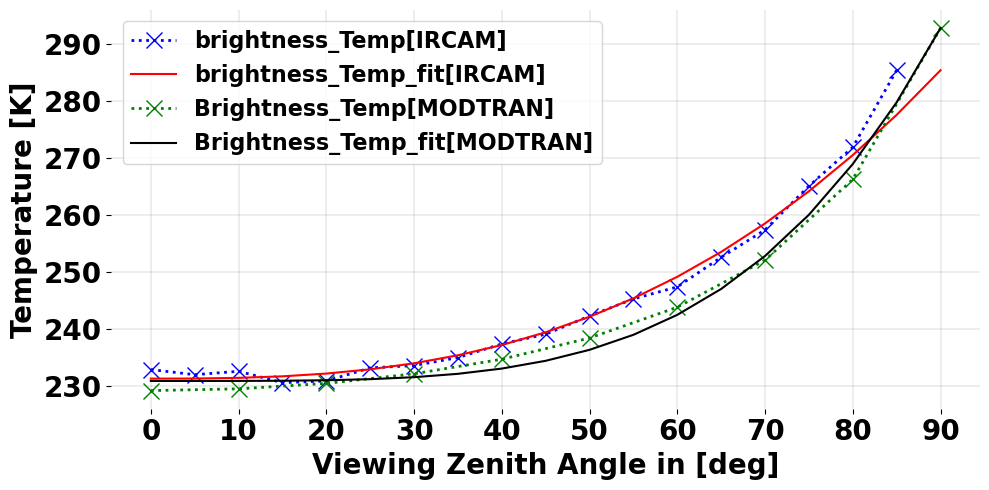

In [96]:
yerr_measured = measured_fit['Temp'].values[:-1] - df_measured['Temp'].values
yerr_modeled = modeled_fit['Temp'].values[0::2] - model_rad['Temp'].values

plt.figure(figsize = (10,5))
plt.plot(df_measured['zenith'],df_measured['Temp'],'bx:',markersize = 12,linewidth = 2,label = 'brightness_Temp[IRCAM]' )
plt.plot(measured_fit['zenith'],measured_fit['Temp'],color = 'red',label = 'brightness_Temp_fit[IRCAM]')

plt.plot(model_rad['zenith'],model_rad['Temp'],'gx:',markersize = 12,linewidth = 2,label = 'Brightness_Temp[MODTRAN]')
plt.plot(modeled_fit['zenith'],modeled_fit['Temp'],color = 'k',label = 'Brightness_Temp_fit[MODTRAN]')
plt.legend(loc = 'best',prop = {'size':16,'weight':'bold'})
plt.xticks(np.arange(0,100,10),fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.xlabel('Viewing Zenith Angle in [deg]', fontweight = 'bold',size = 20)
plt.ylabel('Temperature [K]',fontweight = 'bold',size = 20)
plt.grid(color = 'gray',linewidth = 0.2)
plt.box()
plt.tight_layout()
plt.show()

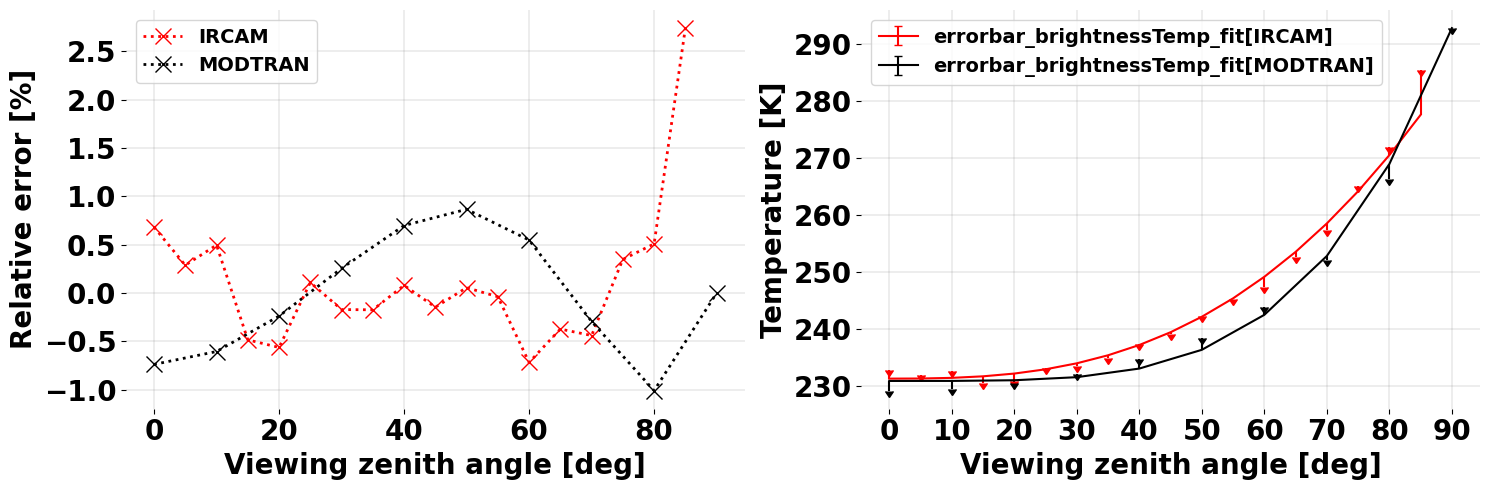

In [101]:
# x_fit

fig = plt.figure(figsize = (15,5))
# plt.subplot(1,2,1)
# plt.plot(df_measured['zenith'],df_measured['Temp'],'bx:',markersize = 12,linewidth = 2,label = 'brightness_Temp[IRCAM]' )
# plt.plot(measured_fit['zenith'],measured_fit['Temp'],color = 'red',label = 'brightness_Temp_fit[IRCAM]')

# plt.plot(model_rad['zenith'],model_rad['Temp'],'gx:',markersize = 12,linewidth = 2,label = 'Brightness_Temp[MODTRAN]')
# plt.plot(modeled_fit['zenith'],modeled_fit['Temp'],color = 'k',label = 'Brightness_Temp_fit[MODTRAN]')
# plt.legend(loc = 'best',prop = {'size':16,'weight':'bold'})
# plt.xticks(np.arange(0,100,10),fontweight = 'bold',size = 20)
# plt.yticks(fontweight = 'bold',size = 20)
# plt.xlabel('Viewing Zenith Angle in [deg]', fontweight = 'bold',size = 20)
# plt.ylabel('Temperature [K]',fontweight = 'bold',size = 20)
# plt.grid(color = 'gray',linewidth = 0.2)
# plt.box()
# plt.tight_layout()

# plt.subplot(2,2,2)
# plt.plot(measured_fit['zenith'][0::2].values[:-1], residual_fit[0::2].values[:-1],'x:',markersize = 12)
# plt.plot(df_measured['zenith'][0::2], residual_act,'rx:',markersize = 12)
# plt.legend(loc = 'best',prop = {'size':16,'weight':'bold'})
# plt.xticks(fontweight = 'bold',size = 20)
# plt.yticks(fontweight = 'bold',size = 20)
# plt.xlabel('Viewing zenith angle [deg]',fontweight = 'bold',size = 20)
# plt.ylabel('Residual [K]',fontweight = 'bold',size = 20)
# plt.grid(color = 'gray', linewidth = 0.2)
# plt.tight_layout()
# plt.box()

# plt.show()

plt.subplot(1,2,1)
plt.plot(df_measured['zenith'].values, rel_residual_mea,'rx:',markersize = 12,linewidth = 2, label= 'IRCAM')
plt.plot(model_rad['zenith'], rel_residual_mod,'kx:',markersize = 12,linewidth = 2, label = 'MODTRAN')
plt.legend(loc = 'best',prop = {'size':14,'weight':'bold'})
plt.xticks(fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.xlabel('Viewing zenith angle [deg]',fontweight = 'bold',size = 20)
plt.ylabel('Relative error [%]',fontweight = 'bold',size = 20)
plt.grid(color = 'gray', linewidth = 0.2)
plt.tight_layout()
plt.box()
# plt.show()
# print(df_measured,residual_act)

plt.subplot(1,2,2)
plt.errorbar(measured_fit['zenith'][:-1],measured_fit['Temp'][:-1],yerr_measured\
             ,uplims = True,lolims = False,color = 'red',\
             label = 'errorbar_brightnessTemp_fit[IRCAM]')
plt.errorbar(modeled_fit['zenith'][0::2],modeled_fit['Temp'][0::2],yerr_modeled\
             ,uplims = True,color = 'k',lolims = False,\
             label = 'errorbar_brightnessTemp_fit[MODTRAN]')

plt.legend(loc = 'best',prop = {'size':14,'weight':'bold'})
plt.grid(color = 'gray',linewidth = 0.2)
# plt.xticks(fontweight = 'bold')
plt.xticks(np.arange(0,100,10),fontweight = 'bold',size = 20)
plt.yticks(fontweight = 'bold',size = 20)
plt.xlabel('Viewing zenith angle [deg]',fontweight = 'bold',size = 20)
plt.ylabel('Temperature [K]',fontweight = 'bold',size = 20)
plt.box()
plt.tight_layout()
plt.show()

In [74]:
df_DWD[(df_DWD.DateTime == '12-08-2020 14:00:00')]

Empty DataFrame
Columns: [DateTime, CWV, dwd_vis, Vis, AOD, Amb_Tem, Dew_Tem, cloud]
Index: []

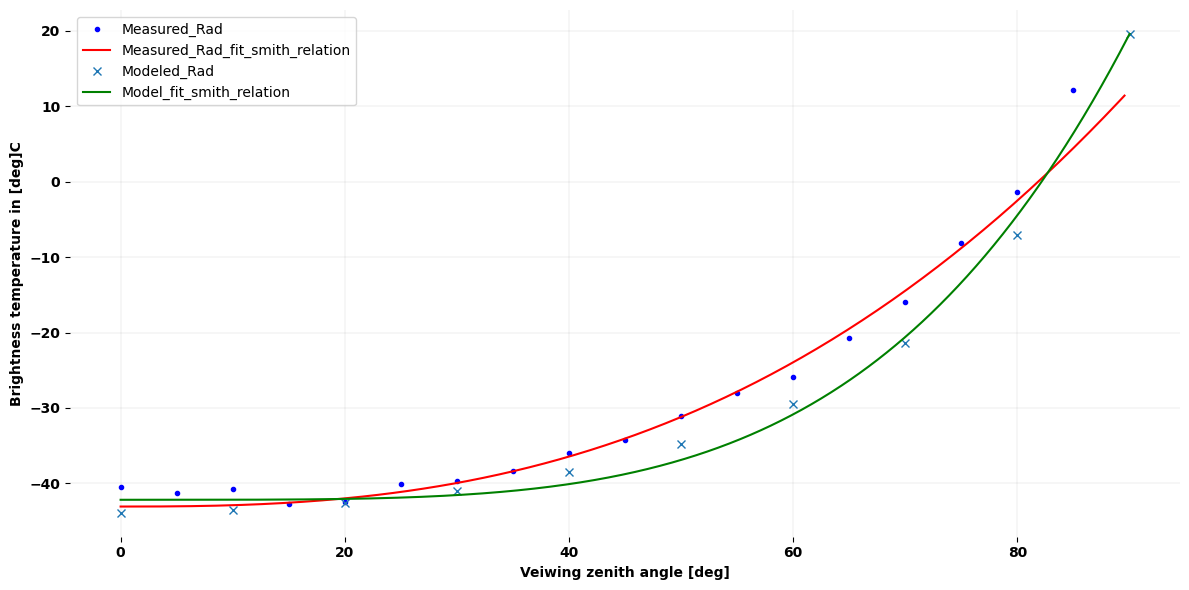

In [248]:
plt.figure(figsize = (12,6))

plt.plot(df_measured['zenith'],df_measured['Temp'],'b.',label = 'Measured_Rad')
plt.plot(df_measured_fit['zenith'],df_measured_fit['Temp'],'r-',label ='Measured_Rad_fit_smith_relation')

plt.plot(model_0['vza'],model_0['Temp'],'x',label = 'Modeled_Rad')
plt.plot(df_modeled['zenith'],df_modeled['Temp'],'g-',label = 'Model_fit_smith_relation')

plt.legend(loc = 'best')
plt.xticks(fontweight= 'bold')
plt.yticks(fontweight= 'bold')
plt.xlabel('Veiwing zenith angle [deg]',fontweight= 'bold')
plt.ylabel('Brightness temperature in [deg]C',fontweight= 'bold')
plt.grid(color = 'gray', linewidth = 0.1)
plt.box()
plt.tight_layout()

